# HANDWRITTEN CALCULATOR

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import shutil
import os
import pathlib
import random
import numpy as np

from collections import Counter
from sklearn.model_selection import train_test_split

%matplotlib inline

import tensorflow as tf
tf.__version__

'2.2.0'

## LOAD DATA

In [20]:
data_root = pathlib.Path('/Users/nhanpham/CoderSchool/AI_calculator/complete_data')

In [9]:
pwd

'/Users/nhanpham/CoderSchool/AI_calculator/model'

### IMAGES

In [21]:
def load_image_paths():
    all_image_paths = [str(path) for path in list(data_root.glob("**/*")) if path.is_file()]
    random.shuffle(all_image_paths)
    return all_image_paths, len(all_image_paths)

In [22]:
all_image_paths, image_count = load_image_paths()
image_count

19450

In [23]:
def check_image(path_list):
    """ Check if image is readable and not DS_STORE file
    """
    
    for index, image_path in enumerate(path_list):
        if (image_path.split('.')[1] != "DS_Store") :
            try:
                image = tf.io.read_file(image_path)
                image = tf.image.decode_jpeg(image, channels=3)
            except:
                print(all_image_paths[index])
            if index % 3000 == 0: 
                print(index)
        else:
            path_list.remove(image_path)

In [24]:
check_image(all_image_paths)

0
3000
6000
9000
12000
15000
18000


### LABELS

In [25]:
def load_labels():
    label_names = sorted(item.name for item in data_root.glob('**/') if item.is_dir())
    return np.array(label_names)

In [26]:
label_names = load_labels()

In [27]:
# might have to remove unrelevant labels
# label_names.remove('.ipynb_checkpoints')
label_names = label_names[:-1].astype(int)
label_names.sort()

In [28]:
label_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [29]:
# create dictionary for prediction index to real label
label_to_index = dict((str(name), index) for index, name in enumerate(label_names))
label_to_index

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10,
 '11': 11,
 '12': 12}

In [30]:
# Get label of every images in the path list
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

# get the first 10 lables to check if the random shuffle actually work
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 10, 11, 11, 12, 3, 1, 2, 0, 11]


In [31]:
# Check the amount of images in each class
count = Counter()
for label in all_image_labels:
    count[label_names[label]] += 1
    
count

Counter({8: 704,
         10: 3771,
         11: 3042,
         12: 2927,
         3: 814,
         1: 1435,
         2: 901,
         0: 1266,
         9: 544,
         6: 1614,
         5: 909,
         4: 993,
         7: 529})

### SPLITING DATASET 

In [32]:
train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

In [33]:
print(len(train_image_paths))
print(len(test_image_labels))

15559
3890


## PREPROCESS

In [34]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = (255 - image)/255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

def visualize_random():
    index = random.randint(0, image_count)
    image_path = all_image_paths[index]
    label = all_image_labels[index]

    # show image
    print(image_path)
    plt.imshow(load_and_preprocess_image(image_path)[:,:,0], cmap='gray')
    plt.grid(False)
    plt.title(label_names[label])
    plt.show()

/Users/nhanpham/CoderSchool/AI_calculator/complete_data/1/1_36734.jpg


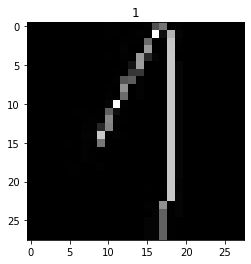

In [35]:
visualize_random()

In [36]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(all_image_paths, all_image_labels):
    """ Load dataset into tensor
    """
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return ds

In [37]:
train_set = create_ds(train_image_paths, train_image_labels)
test_set = create_ds(test_image_paths, test_image_labels)

## MODEL

In [40]:
def build_model(learning_rate=0.01):  
    model = tf.keras.Sequential([   
          tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(28, 28, 1)),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Flatten(),

          tf.keras.layers.Dense(200, use_bias=False),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Activation('relu'),

          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Dense(len(label_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [41]:
cnn_model = build_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 12)        36        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)         

## TRAIN

In [42]:
#  Setting up Callbacks 
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])

    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])

In [43]:
steps_per_epoch = len(train_image_labels) // BATCH_SIZE
val_steps_per_epoch = len(test_image_labels) // BATCH_SIZE
batch_stats_callback = CollectBatchStats()

# FIT THE DATA NOW
history = cnn_model.fit(train_set, 
                        epochs=5, 
                        steps_per_epoch=steps_per_epoch,
                        callbacks = [batch_stats_callback],
                        validation_data=test_set,
                        validation_steps=val_steps_per_epoch)

Epoch 1/5
486/486 [==============================] - 32s 66ms/step - loss: 0.1962 - accuracy: 0.9414 - val_loss: 0.2019 - val_accuracy: 0.9329
Epoch 2/5
486/486 [==============================] - 24s 49ms/step - loss: 0.0481 - accuracy: 0.9853 - val_loss: 0.0586 - val_accuracy: 0.9814
Epoch 3/5
486/486 [==============================] - 24s 49ms/step - loss: 0.0340 - accuracy: 0.9895 - val_loss: 0.0210 - val_accuracy: 0.9935
Epoch 4/5
486/486 [==============================] - 27s 56ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.1131 - val_accuracy: 0.9765
Epoch 5/5
486/486 [==============================] - 33s 67ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0575 - val_accuracy: 0.9827


In [44]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()

def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()

<Figure size 432x288 with 0 Axes>

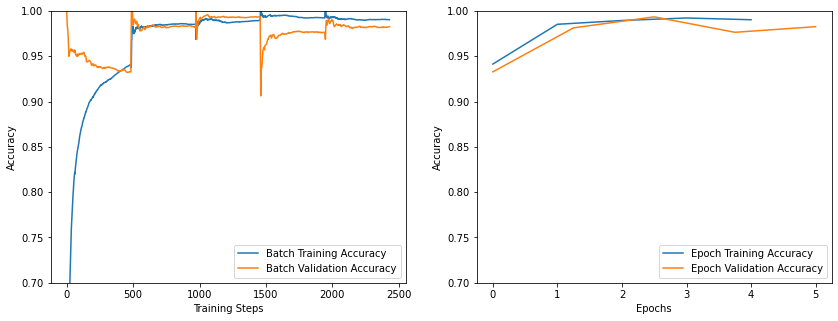

In [45]:
def plot_training_results(training_acc, val_acc, epoch_acc, epoch_val_acc):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=[14, 5])

    # Plot batchs training & validation accuracy
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Training Steps")

    training_steps = len(training_acc)
    test_steps = len(val_acc)
    ax[0].plot(training_acc, label='Batch Training Accuracy')
    ax[0].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
    ax[0].set_ylim([0.7,1])
    ax[0].legend(loc='lower right')

    # Plot epochs training & validation accuracy
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epochs")

    train_epochs = len(epoch_acc)
    val_epochs = len(epoch_val_acc)
    ax[1].plot(epoch_acc, label='Epoch Training Accuracy')
    ax[1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
    ax[1].set_ylim([0.7,1])
    ax[1].legend(loc='lower right')

    plt.show()

plot_training_results(batch_stats_callback.batch_acc,      #batch stats
                      batch_stats_callback.batch_val_acc,  #batch stats
                      history.history['accuracy'],         #epoch stats
                      history.history['val_accuracy']      #epoch stats
                     )

## TEST

In [46]:
# Take 1 batch out for testing
for image_batch, label_batch in test_set:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 28, 28, 1)
Label batch shape:  (32,)


In [47]:
# Predict
label_names = np.array(label_names)
predicted_batch = cnn_model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

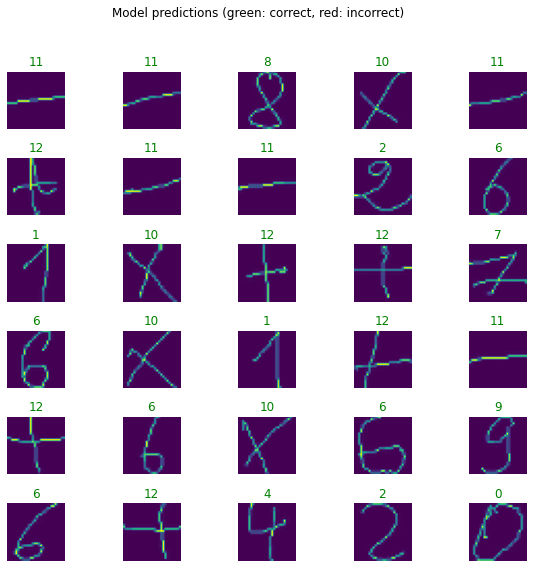

In [48]:
# Plot the result
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n][:,:,0])
    color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
    plt.title(predicted_label_batch[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## EXPORT MODEL 

In [49]:
cnn_model.save('maths.h5')

In [53]:
# recheck loaded model

reloaded_model = tf.keras.models.load_model('/Users/nhanpham/CoderSchool/AI_calculator/model/maths.h5')
reloaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 12)        36        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)         

In [54]:
# test if the current model result and export model result is consistent
result_batch = cnn_model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [55]:
# check if there is any difference
abs(reloaded_result_batch - result_batch).max()

0.0